# 1.0 Load and prepare the data

Setup data directory

In [1]:
base_dir = './data'

In [2]:
from torchvision.datasets import ImageFolder

images = ImageFolder(base_dir + '/all')

images_count = len(images)
num_classes = len(images.classes)

print(f"Number of images: {images_count}")
print(f"Number of classes: {num_classes}")

Number of images: 39209
Number of classes: 43


Preview samples from each class

In [3]:
import random
from utils.display import plot_images

class_idxs = {}
for idx, (_, label) in enumerate(images):
    if label not in class_idxs:
        class_idxs[label] = []

    class_idxs[label].append(idx)

sample_idxs = [random.choice(class_idxs[c]) for c in range(num_classes)]
samples = [images[i][0] for i in sample_idxs]

plot_images(list(samples), ncols=9)

KeyboardInterrupt: 

Check class distribution

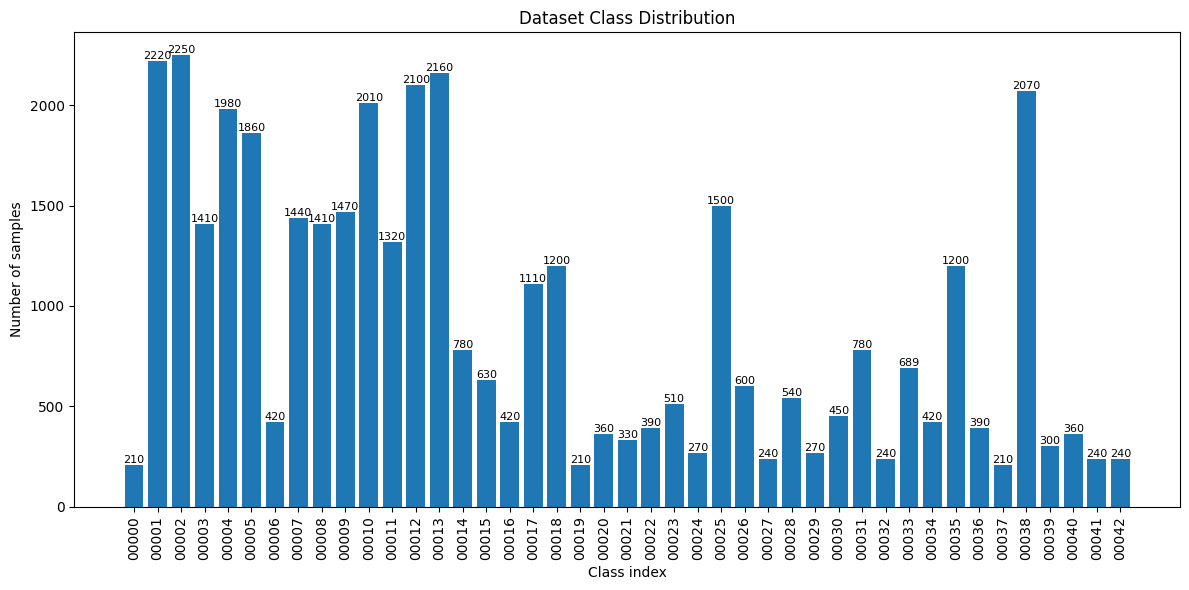

In [38]:
import matplotlib.pyplot as plt

counts = [len(class_idxs[i]) for i in range(num_classes)]

plt.figure(figsize=(12, 6))
bars = plt.bar(range(num_classes), counts)
plt.xlabel('Class index')
plt.ylabel('Number of samples')
plt.title('Dataset Class Distribution')
plt.xticks(range(num_classes), images.classes, rotation=90)

for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y, int(y), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Check brightness and contrast

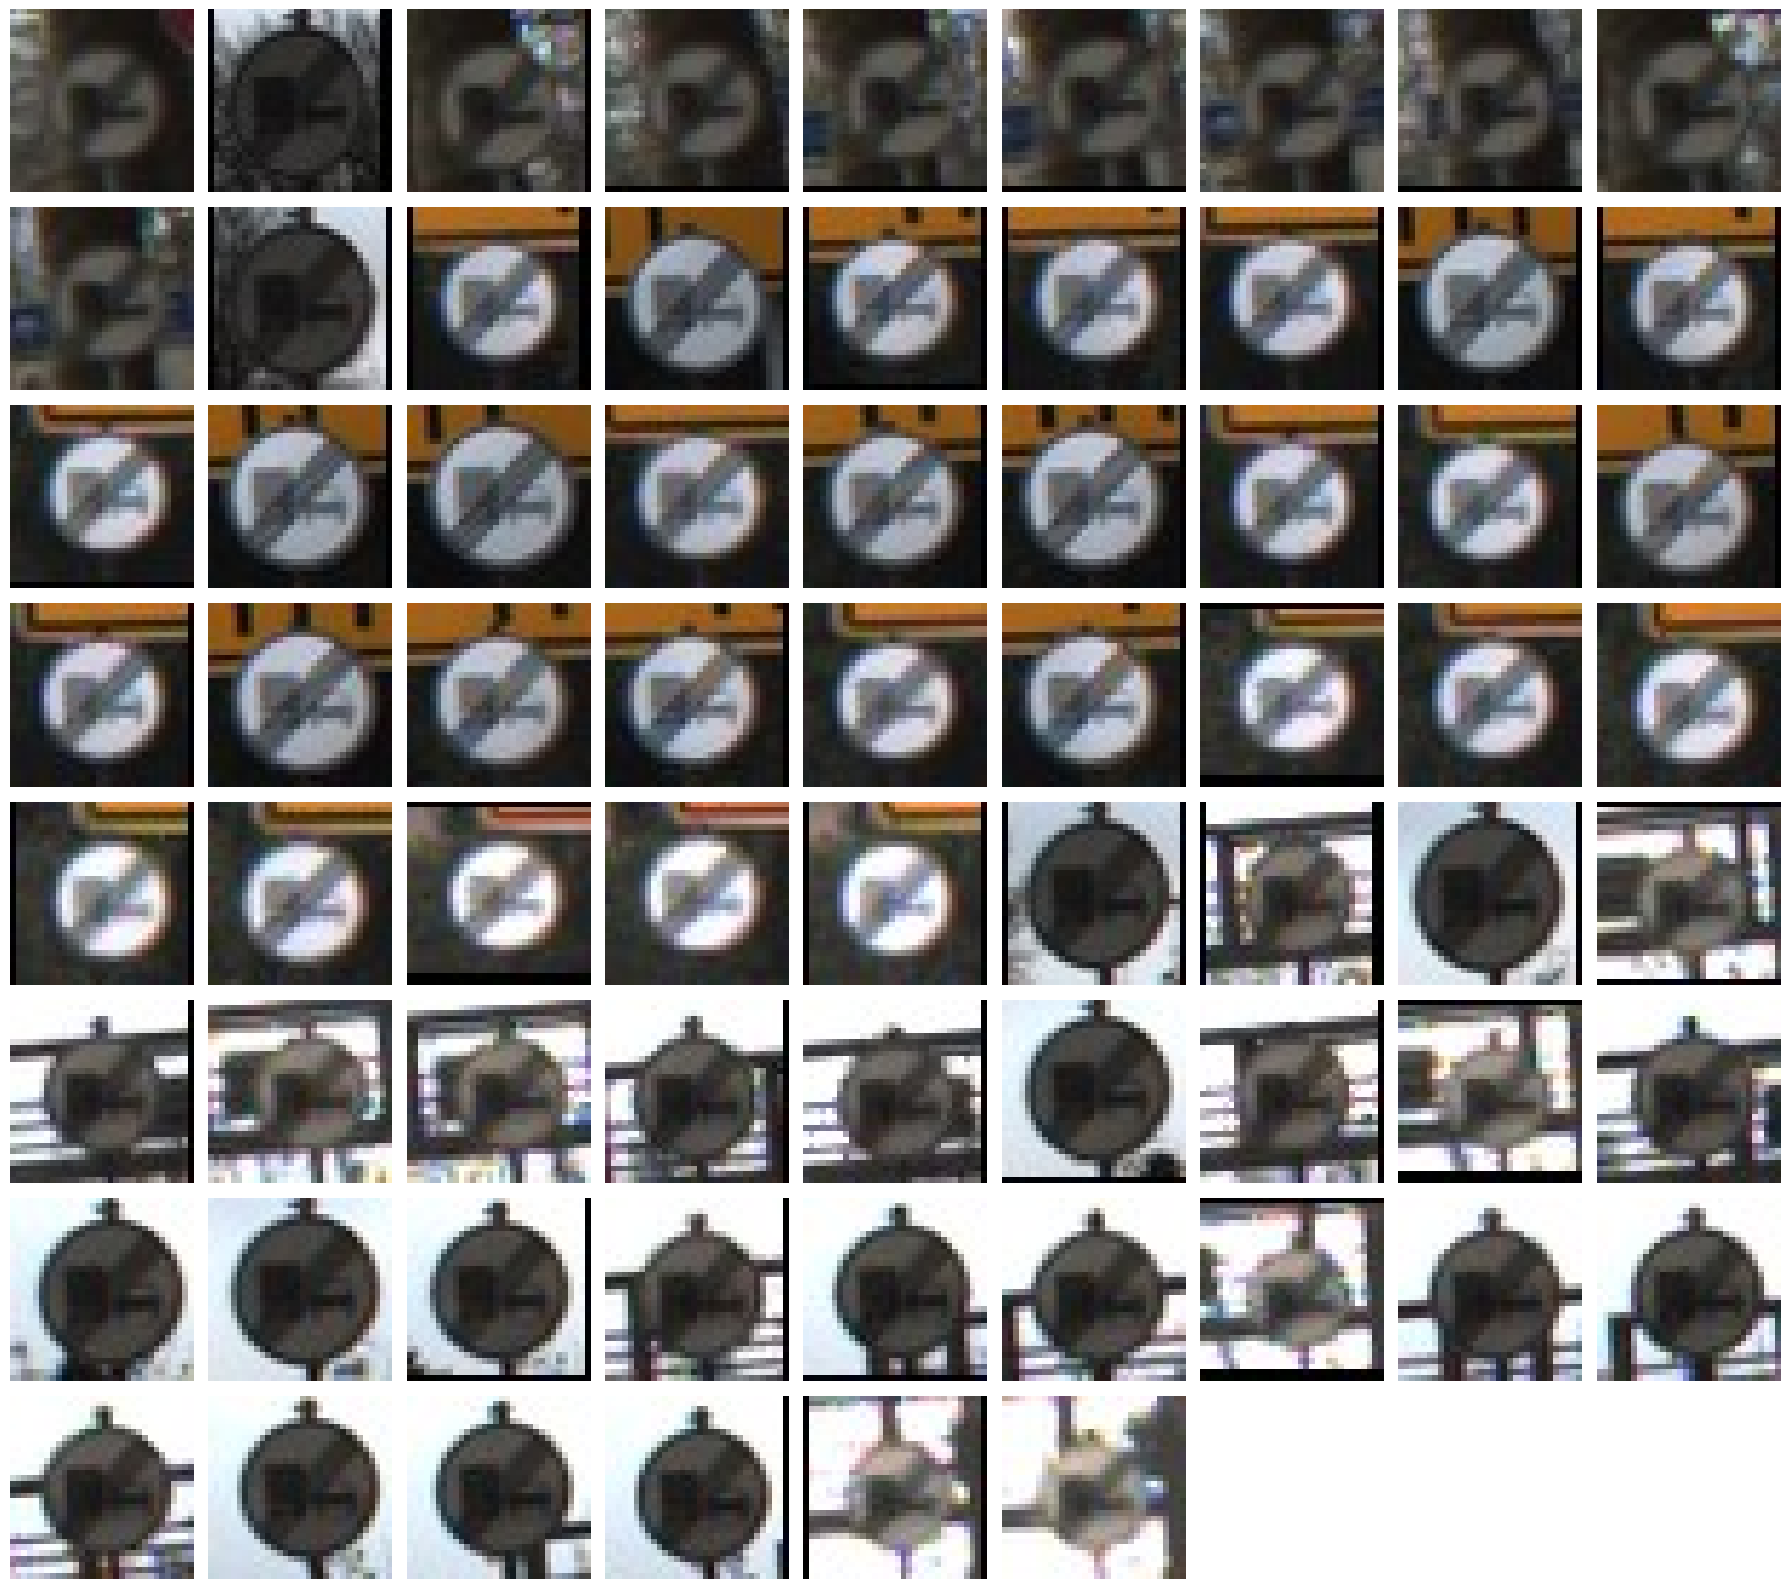

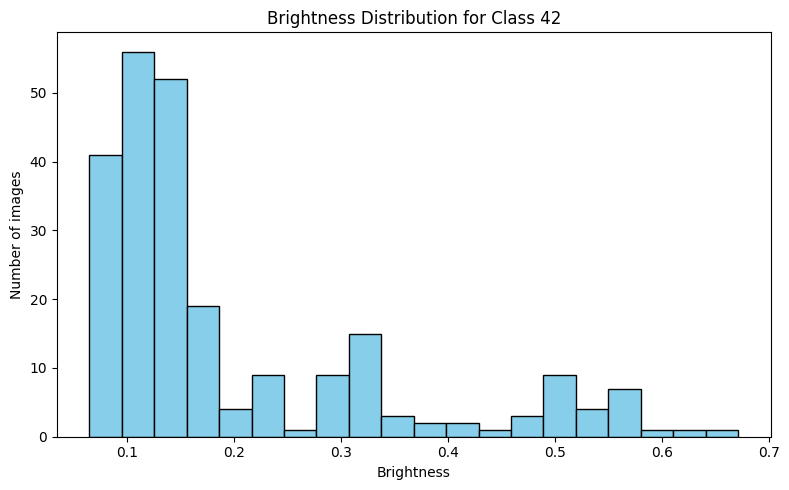

In [ ]:
from torchvision import transforms

# compute brightness for each image in class 42
to_tensor = transforms.ToTensor()

brightness_list = [(to_tensor(images[i][0]).mean().item(), i) for i in class_idxs[42]]
brightness_list.sort(key=lambda x: x[0])

# select 9 darkest and 9 brightest
sorted_images = [images[i][0] for (b, i) in brightness_list if b > 0.2]

plot_images(sorted_images, ncols=9)

# Plot histogram of brightness for class 42
brightness_vals = [b for b, _ in brightness_list]

plt.figure(figsize=(8, 5))
plt.hist(brightness_vals, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Brightness')
plt.ylabel('Number of images')
plt.title('Brightness Distribution for Class 42')
plt.tight_layout()
plt.show()

Split the data into train and test sets

In [4]:
from sklearn.model_selection import train_test_split

paths, labels = zip(*images.samples)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    paths, 
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

print(f"Number of training images: {len(train_paths)}")
print(f"Number of test images: {len(test_paths)}")

Number of training images: 31367
Number of test images: 7842


Compute mean and standard deviation of the training set

In [5]:
from PIL import Image
import torch
from torchvision import transforms

sum_c = torch.zeros(3)
sum_sq_c = torch.zeros(3)
num_pixels = 0

to_tensor = transforms.ToTensor()

for src in train_paths:
    img = Image.open(src).convert('RGB')
    t = to_tensor(img)  # [C, H, W]
    sum_c += t.sum(dim=(1, 2))
    sum_sq_c += (t**2).sum(dim=(1, 2))
    num_pixels += t.shape[1] * t.shape[2]

mean = sum_c / num_pixels
std = (sum_sq_c / num_pixels - mean**2).sqrt()

print(f"Mean: {mean.tolist()}")
print(f"Std: {std.tolist()}")

Mean: [0.3186241388320923, 0.2931755483150482, 0.3017965853214264]
Std: [0.2762017548084259, 0.2654302418231964, 0.2686000168323517]


Save the data

In [6]:
import os
import shutil


def save_subset(dest: str, paths: list[str], labels: list[int], flatten: bool = False):
    os.makedirs(dest, exist_ok=True)

    for path, label in zip(paths, labels):
        dest_path = os.path.join(dest, images.classes[label]) if not flatten else dest
        os.makedirs(dest_path, exist_ok=True)
        shutil.copy(path, os.path.join(dest_path, os.path.basename(path)))
    

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
test_dir_flat = os.path.join(base_dir, 'test_flat')


if not os.path.exists(train_dir):
    save_subset(train_dir, train_paths, train_labels)


if not os.path.exists(test_dir):
    save_subset(test_dir, test_paths, test_labels)

if not os.path.exists(test_dir_flat):
    save_subset(test_dir_flat, test_paths, test_labels, flatten=True)